In [1]:
import os 
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import matplotlib.pyplot as plt

In [3]:
#load gps coordinates
## testing with data_gps.
data_gps = pd.read_csv('../data/data_gps.csv')
data_gps['code_INSEE'] = ['0'+str(X) if len(str(X)) < 5 else X for X in data_gps['code_INSEE']]
data_gps.columns = ['CODE_INSEE','latitude','longitude']


In [24]:
def plot_gps_column(data,column):
    #data = pd.merge(dataframe_total,data_gps,on='CODE_INSEE')
    fig, ax = plt.subplots(figsize = (10,8))
    index = data[column].isna()
    if index.sum():
        ax.scatter(data.longitude[index], data.latitude[index], c='k', s=20)
        sc = ax.scatter(data.longitude[-index], data.latitude[-index], c=data[column][-index], s=20,cmap='Spectral')
    else:
        sc = ax.scatter(data.longitude, data.latitude, c=data[column], s=20,cmap='Spectral')
    ax.set_xlim(-6.5, 10.5)
    ax.set_ylim(41.5, 51.5)
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    ax.set_title("Column : {}, NaNs({})".format(column,index.sum()))
    fig.colorbar(sc)
    


# 1. Analyse du mergev2

In [9]:
mergev2 = pd.read_csv('../data/processed/data_merge_V2_FIX.csv')
mergev2_gps = pd.merge(mergev2,data_gps,on="CODE_INSEE")
mergev2_gps.loc[0,:]

Unnamed: 0                                    0
CODE_INSEE                                01001
DEP                                          01
LIBCOM                  L'Abergement-Clémenciat
TX_NSCOL15P                             52.1543
TX_MENSEUL                              22.8236
TX_FAMMONO                               4.8315
TX_65ETPLUS                             23.7792
TX_25ETMOINS                            11.3093
COUVERTURE_HD_THD                             1
TX_BENEF_MINIMAS_SOC                          1
TX_DEMANDEUR_EMPLOIS                      18.91
TX_POVERTY                              19.4795
latitude                                46.1534
longitude                               4.92611
Name: 0, dtype: object

-------
Les variables TX_BENEF_MINIMAS_SOC et COUVERTURE_HD_THD ont seulement la valeur d'1

In [18]:
mergev2_gps.TX_BENEF_MINIMAS_SOC.unique()

array([ 1., nan])

In [19]:
mergev2_gps.COUVERTURE_HD_THD.unique()

array([ 1., nan])

In [16]:
mergev2_gps.describe()

,Unnamed: 0,TX_NSCOL15P,TX_MENSEUL,TX_FAMMONO,TX_65ETPLUS,TX_25ETMOINS,COUVERTURE_HD_THD,TX_BENEF_MINIMAS_SOC,TX_DEMANDEUR_EMPLOIS,TX_POVERTY,latitude,longitude
count,37960.000000,37930.000000,37923.000000,37923.000000,37930.000000,37930.000000,37960.0,37960.0,37944.000000,38230.000000,38236.000000,38236.000000
mean,17509.014858,54.129088,29.137810,7.489017,26.258572,11.002415,1.0,1.0,22.997103,26.080269,46.687136,2.786285
std,10107.634503,9.559369,8.872472,5.607340,7.876606,3.400636,0.0,0.0,4.612227,6.100359,4.518379,4.961569
min,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,6.894494,9.387755,-21.340107,-61.779579
25%,8758.750000,48.158826,23.076923,4.100926,20.768410,9.016412,1.0,1.0,19.784857,21.253129,45.110806,0.722083
50%,17594.500000,54.612545,28.352411,7.247656,25.245867,11.063048,1.0,1.0,22.758716,26.006932,47.370637,2.726025
75%,26288.250000,60.831467,34.217756,10.125495,30.882733,12.911419,1.0,1.0,25.596068,30.690537,48.819304,5.002333
max,35009.000000,100.000000,100.000000,100.000000,100.000000,52.142112,1.0,1.0,54.744097,72.405498,51.073044,55.754522


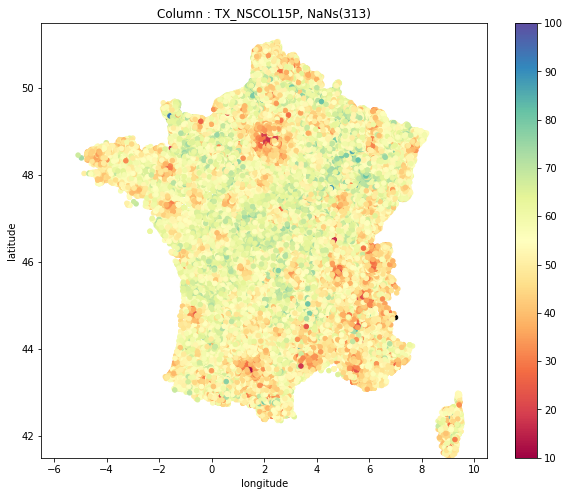

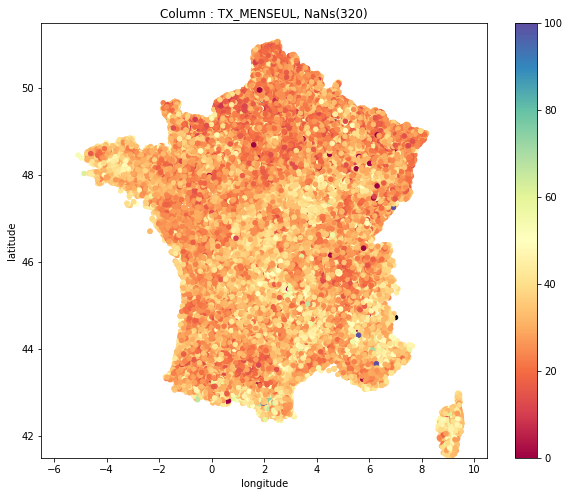

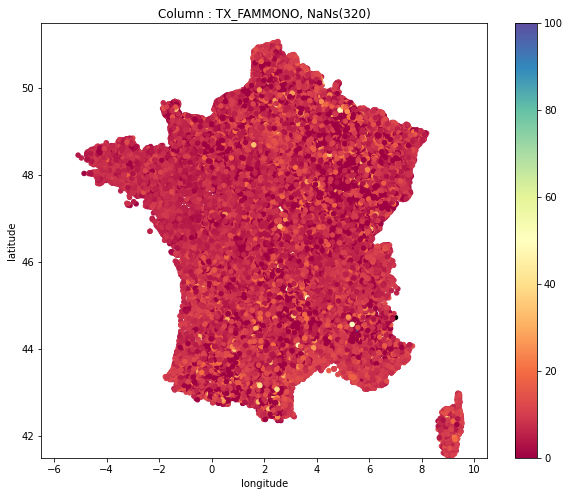

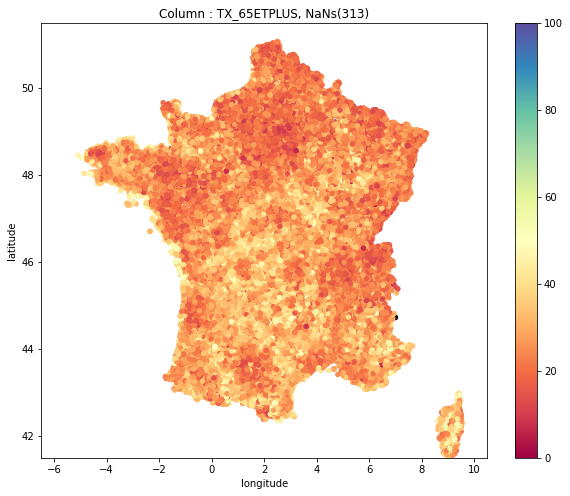

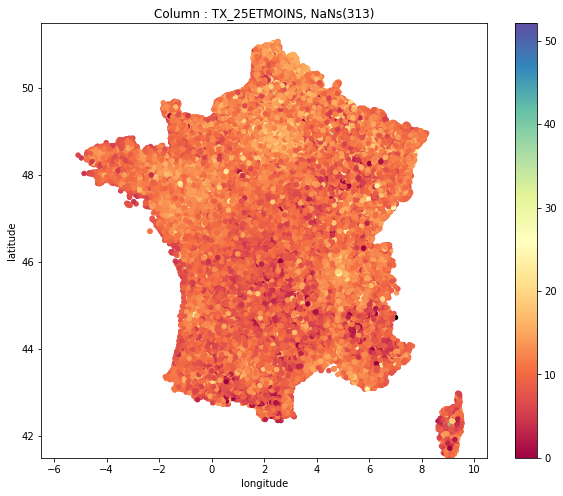

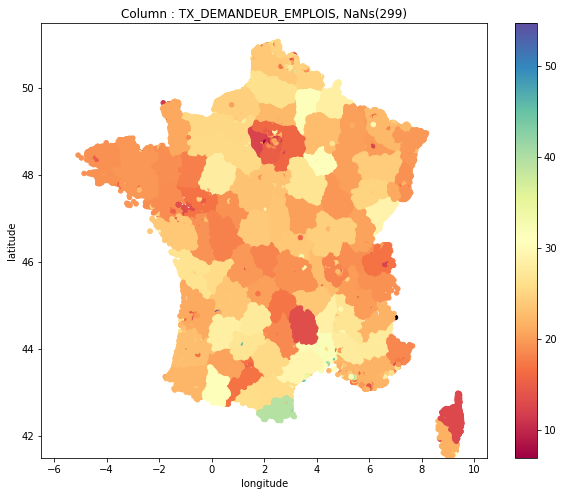

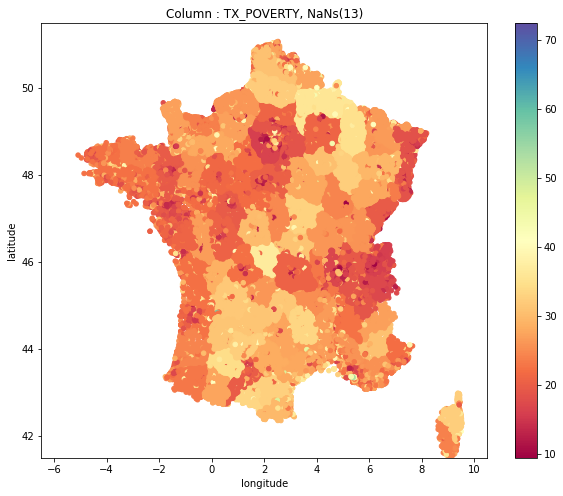

In [25]:
columns = ['TX_NSCOL15P','TX_MENSEUL','TX_FAMMONO','TX_65ETPLUS','TX_25ETMOINS','TX_DEMANDEUR_EMPLOIS','TX_POVERTY']
for c in columns:
    plot_gps_column(mergev2_gps,c)

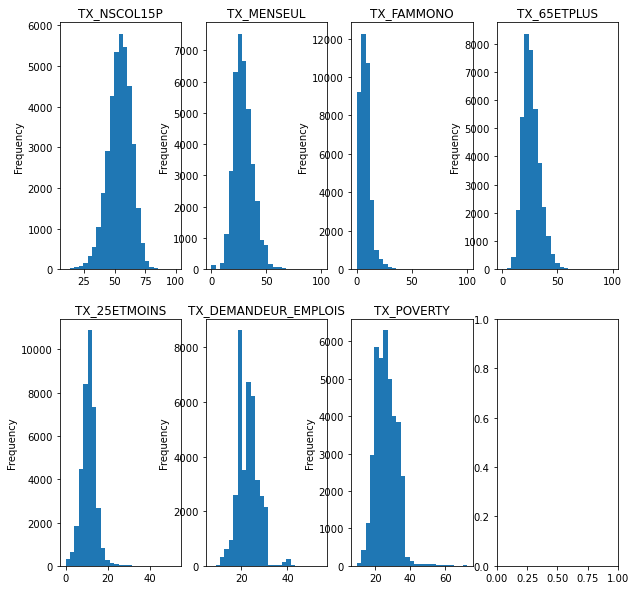

In [47]:
fig,axes = plt.subplots(2,len(columns)//2 +1,figsize=(10,10))
ax = axes.ravel()
for i,col in enumerate(columns):    
    mergev2_gps[col].plot(kind='hist',bins=25,ax=ax[i])
    ax[i].set_title(col)
